In [ ]:
import math
import torch
import random
import tarfile
import torchtext
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
SEED = 4444
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
with tarfile.open("/content/drive/MyDrive/MT/training.tar.gz", "r") as tf:
  print("Opened tarfile")
  tf.extractall(path="/content")
  print("All files extracted")

Opened tarfile
All files extracted


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
en_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
def de_tokenizer(sentence):
  return de_tok_model(sentence)

def en_tokenizer(sentence):
  return en_tok_model(sentence)

In [ ]:
class Data():
  def __init__(self, en_filename, de_filename):
    self.en_file = open(en_filename, mode='rt', encoding='utf-8')
    self.en_text = self.en_file.read()
    self.en_file.close()
    self.de_file = open(de_filename, mode='rt', encoding='utf-8')
    self.de_text = self.de_file.read()
    self.de_file.close()
    self.en_text = self.en_text.strip().split('\n')
    self.de_text = self.de_text.strip().split('\n')
  def data(self):
    return self.en_text, self.de_text

In [ ]:
class Vocab():
  def __init__(self, en_filename, de_filename):
    self.en_len = 0
    self.de_len = 0
    self.en_count = Counter()
    self.de_count = Counter()
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    for idx in range(len(self.en_data)):
      self.en_sent = self.en_data[idx]
      self.de_sent = self.de_data[idx]
      self.en_sent = ['<SOS>'] + en_tokenizer(self.en_sent.lower().strip()) + ['<EOS>']
      self.de_sent = ['<SOS>'] + de_tokenizer(self.de_sent.lower().strip()) + ['<EOS>']
      if(len(self.en_sent) > self.en_len):
        self.en_len = len(self.en_sent)
      if(len(self.de_sent) > self.de_len):
        self.de_len = len(self.de_sent)
      self.en_count.update(self.en_sent)
      self.de_count.update(self.de_sent)
    self.en_vocab = set()
    for k,c in self.en_count.items():
      if len(self.en_vocab)<8190 :
        self.en_vocab.add(k)
    self.en_vocab.add('<PAD>')
    self.de_vocab = set()
    for k,c in self.de_count.items():
      if len(self.de_vocab)<8190 :
        self.de_vocab.add(k)
    self.de_vocab.add('<PAD>')
  def vocab(self):
    return self.en_vocab, self.de_vocab, self.en_len, self.de_len

In [ ]:
class multi30K(Dataset):
  def __init__(self, en_filename, de_filename):
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    self.en_vocab, self.de_vocab, self.en_len, self.de_len = Vocab(en_filename, de_filename).vocab()
    self.en_word2idx = {w: idx for (idx, w) in enumerate(self.en_vocab)}
    self.en_word2idx.update({'<UNK>' : len(self.en_word2idx)})
    self.en_idx2word = {idx: w for (idx, w) in enumerate(self.en_vocab)}
    self.en_idx2word.update({len(self.en_idx2word) : '<UNK>'})
    self.de_word2idx = {w: idx for (idx, w) in enumerate(self.de_vocab)}
    self.de_word2idx.update({'<UNK>' : len(self.de_word2idx)})
    self.de_idx2word = {idx: w for (idx, w) in enumerate(self.de_vocab)}
    self.de_idx2word.update({len(self.de_idx2word) : '<UNK>'})

  def __len__(self):
    return len(self.en_data)

  def __getitem__(self, index):
    en_sent = self.en_data[index]
    de_sent = self.de_data[index]
    en_sent = ['<SOS>'] + en_tokenizer(en_sent.lower().strip()) + ['<EOS>']
    de_sent = ['<SOS>'] + de_tokenizer(de_sent.lower().strip()) + ['<EOS>']
    for i in range(len(en_sent)):
      if en_sent[i] in self.en_vocab:
        en_sent[i] = self.en_word2idx[en_sent[i]]
      else:
        en_sent[i] = self.en_word2idx['<UNK>']
    for i in range(len(de_sent)):
      if de_sent[i] in self.de_vocab:
        de_sent[i] = self.de_word2idx[de_sent[i]]
      else:
        de_sent[i] = self.de_word2idx['<UNK>']
    for i in range(len(en_sent), self.en_len):
      en_sent.append(self.en_word2idx['<PAD>'])
    for i in range(len(de_sent), self.de_len):
      de_sent.append(self.de_word2idx['<PAD>'])
    en_sent = torch.tensor(en_sent)
    de_sent = torch.tensor(de_sent)
    return en_sent, de_sent

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim_model, dropout_p, max_len):
    super().__init__()
    self.dropout = nn.Dropout(dropout_p)

    pos_encoding = torch.zeros(max_len, dim_model)
    positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
    division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(100.0)) / dim_model)

    pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

    pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

    pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
    self.register_buffer("pos_encoding",pos_encoding)

  def forward(self, token_embedding: torch.tensor) -> torch.tensor:
    return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [ ]:
class Model(nn.Module):
  def __init__(self, embedding_dim, en_vocab_size, de_vocab_size):
    super(Model, self).__init__()
    self.en_embedding = nn.Embedding(en_vocab_size, embedding_dim)
    self.de_embedding = nn.Embedding(de_vocab_size, embedding_dim)
    self.positional_encoder = PositionalEncoding(dim_model = embedding_dim, dropout_p = 0.1, max_len = 500)
    self.transformer = nn.Transformer(d_model = embedding_dim, num_encoder_layers = 2, num_decoder_layers = 2, batch_first = False)
    self.L1 = nn.Linear(embedding_dim, de_vocab_size)

  def forward(self, en_sent, de_sent):
    en_embed = self.en_embedding(en_sent)
    de_embed = self.de_embedding(de_sent)
    en_embed = en_embed.permute(1,0,2)
    de_embed = de_embed.permute(1,0,2)
    src = self.positional_encoder(en_embed)
    tgt = self.positional_encoder(de_embed)

    transformer_out = self.transformer(src,tgt,
                      src_mask = torch.zeros((en_sent.size(1), en_sent.size(1)), device=device).type(torch.bool),
                      tgt_mask = nn.Transformer.generate_square_subsequent_mask(de_sent.size(1), device=device),
                      src_key_padding_mask = (en_sent == dataset.en_word2idx["<PAD>"]),
                      tgt_key_padding_mask = (de_sent == dataset.de_word2idx["<PAD>"]),
                      memory_key_padding_mask = (en_sent == dataset.en_word2idx["<PAD>"]))

    out = self.L1(transformer_out)
    return F.log_softmax(out, dim=-1)

In [ ]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[0], batch[1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        pred = model(X, y_input)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()
    epoch_loss = total_loss / len(dataloader)
    epoch_perplexity = math.exp(epoch_loss)

    return epoch_loss, epoch_perplexity

In [ ]:
def fit(model, opt, loss_fn, train_dataloader, epochs):
    train_loss_list = []
    train_perplexity_list = []

    print("Training Transformer Model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss, train_perplexity = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        train_perplexity_list  += [train_perplexity]

    print(f"Training loss: {train_loss:.4f}")
    print(f"Training perplexity: {train_perplexity:.4f}")
    return train_loss_list, train_perplexity_list

In [ ]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

In [ ]:
dataset = multi30K('/content/train.en', '/content/train.de')
data = DataLoader(dataset, **params)

In [ ]:
embedding_dim = 400
en_vocab_size = len(dataset.en_vocab)
de_vocab_size = len(dataset.de_vocab)

In [ ]:
print("German Vocab Size : ", de_vocab_size)
print("English Vocab Size : ", en_vocab_size)

German Vocab Size :  8191
English Vocab Size :  8191


In [ ]:
model = Model(embedding_dim, en_vocab_size+1, de_vocab_size+1)
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.de_word2idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loss_func, perplexity = fit(model, optimizer, criterion, data, 10)

Training Transformer Model
------------------------- Epoch 1 -------------------------
------------------------- Epoch 2 -------------------------
------------------------- Epoch 3 -------------------------
------------------------- Epoch 4 -------------------------
------------------------- Epoch 5 -------------------------
------------------------- Epoch 6 -------------------------
------------------------- Epoch 7 -------------------------
------------------------- Epoch 8 -------------------------
------------------------- Epoch 9 -------------------------
------------------------- Epoch 10 -------------------------
Training loss: 1.2058
Training perplexity: 3.3393


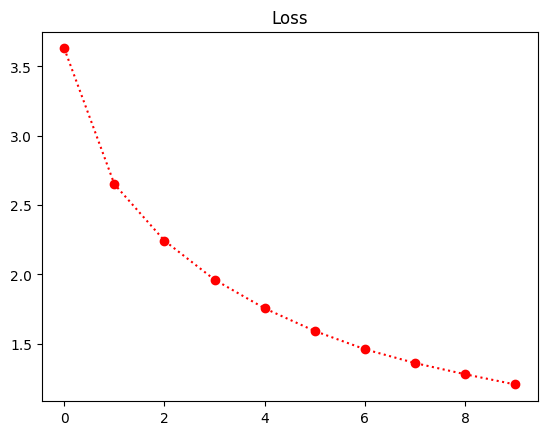

In [ ]:
plt.plot(loss_func, 'o:r')
plt.title("Loss")
plt.show()

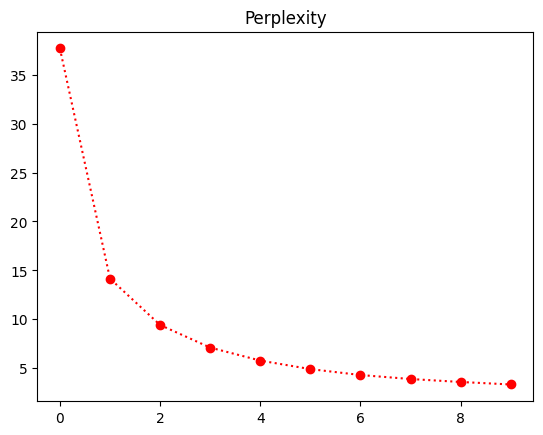

In [ ]:
plt.plot(perplexity, 'o:r')
plt.title("Perplexity")
plt.show()

In [ ]:
def Predict(model, input_sequence, max_length=dataset.de_len, SOS_token=dataset.de_word2idx["<SOS>"], EOS_token=dataset.de_word2idx["<EOS>"]):
  model.eval()
  y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
  num_tokens = len(input_sequence[0])

  for _ in range(max_length):
    with torch.no_grad():
      pred = model(input_sequence, y_input)

    next_item = pred.topk(1)[1].view(-1)[-1].item()
    next_item = torch.tensor([[next_item]], device=device)

    y_input = torch.cat((y_input, next_item), dim=1)

    if next_item.view(-1).item() == EOS_token:
      break

  y_input = y_input.view(-1).tolist()
  sentence = [dataset.de_idx2word[id] for id in y_input]
  return sentence

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def CalcBELU(model, dataset):
  belu_score = 0
  for n in range(1,9):
    true_translation = []
    (en,de) = dataset[-n]
    en = en.resize_(1, en.size(0)).to(device)
    pred_translation = Predict(model, en)
    for id in de:
      if id != dataset.de_word2idx['<PAD>']:
        true_translation.append(dataset.de_idx2word[int(id)])
    belu_score += float(sentence_bleu([pred_translation], true_translation))
  return belu_score/8

In [ ]:
print("Obtained BELU Score : ", CalcBELU(model, dataset)*100)

Obtained BELU Score :  38.795851260454526


In [ ]:
txt = input("Enter A Text : ")
txt = en_tokenizer(txt.lower().strip())
for i in range(len(txt)):
  if txt[i] in dataset.en_vocab:
    txt[i] = dataset.en_word2idx[txt[i]]
  else:
    txt[i] = dataset.en_word2idx['<UNK>']
txt = torch.tensor(txt)
txt.resize_(1, len(txt))
txt = txt.to(device)
german = Predict(model, txt)
print(german)

Enter A Text : 
